In [1451]:
# Importamos los modulos necesarios
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt


In [1452]:
# Cargamos los datasets
developer_types = pd.read_csv('developer_types_202109151758.csv')
language_proficiencies = pd.read_csv('language_proficiencies_202109151810.csv')
languages = pd.read_csv('languages_202109151809.csv')
skill_types = pd.read_csv('skill_types_202109151806.csv')
skills = pd.read_csv('skills_202109151806.csv')
user_developer_types = pd.read_csv('user_developer_types_202109151759.csv')
user_languages = pd.read_csv('user_languages_202109151809.csv')
user_profiles = pd.read_csv('user_profiles_202109151825.csv')
user_skills = pd.read_csv('user_skills_202109151805.csv')
user_statuses = pd.read_csv('user_statuses_202109151812.csv')
users = pd.read_csv('users_202109151811.csv')
working_statuses = pd.read_csv('working_statuses_202109151805.csv')
world_countries = pd.read_csv('world_countries_202109151807.csv')

In [1453]:
# Verificación de número de usuarios
print('Número de usuarios: ', users.shape[0])

Número de usuarios:  959


In [1454]:
# Empezamos a armar nuestra tabla "user_data" haciendo joins con toda la data disponible
# Status de usuarios
user_data = users[['id', 'activated_at']].merge(user_statuses[['label']], left_on = users.user_status_id, right_on = user_statuses.id, how='left')
user_data = user_data[['id', 'activated_at', 'label']]
user_data = user_data.rename(columns = {'label':'user_status'})

In [1455]:
# Perfil del usuario (IDs: años de experiencia, status laboral y pais)
user_profiles = user_profiles.rename(columns = {'user_id':'id'})
user_data = user_data.merge(user_profiles, on = 'id', how = 'left')

In [1456]:
# Status laboral
working_statuses = working_statuses.rename(columns = {'id':'working_status_id'})
user_data['working_status_id'] = user_data['working_status_id'].fillna(0)
user_data['working_status_id'] = user_data['working_status_id'].astype({'working_status_id' : 'int64'})

user_data = user_data.merge(working_statuses, on='working_status_id', how='left')
user_data.rename(columns={"name": "working_status"}, inplace=True)

In [1457]:
# Pais
# Agreguemos el continente ya que puede ser util para el analisis:
conditions = [(world_countries['continent_id'] == 1), (world_countries['continent_id'] == 2), (world_countries['continent_id'] == 3),
(world_countries['continent_id'] == 4), (world_countries['continent_id'] == 6),  (world_countries['continent_id'] == 7)]

values = ['Asia', 'Europa', 'África', 'Oceanía', 'Norte y Centroamérica', 'Sudamérica y El Caribe']
world_countries['continent'] = np.select(conditions, values)
world_countries = world_countries[['id', 'name', 'continent']]

# Join country
world_countries.rename(columns={"id": "country_id", "name":"country"}, inplace=True)
user_data['country_id'] = user_data['country_id'].fillna(0)
user_data['country_id'] = user_data['country_id'].astype({'country_id' : 'int64'})
user_data = user_data.merge(world_countries, on='country_id', how='left')
user_data = user_data.drop(['working_status_id', 'country_id'], axis=1)

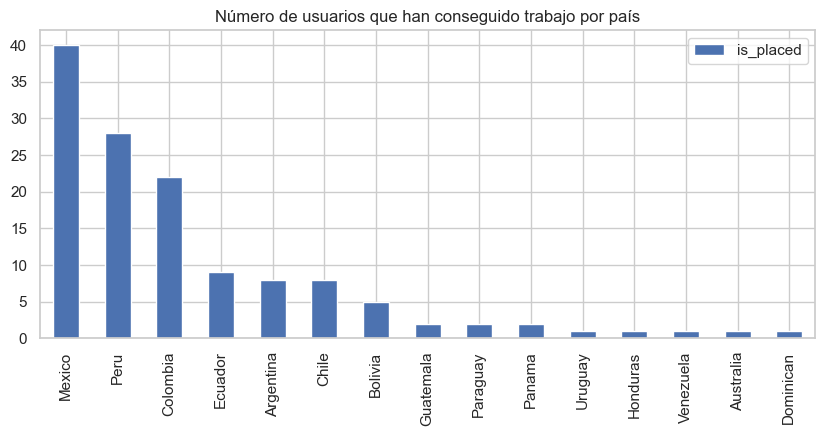

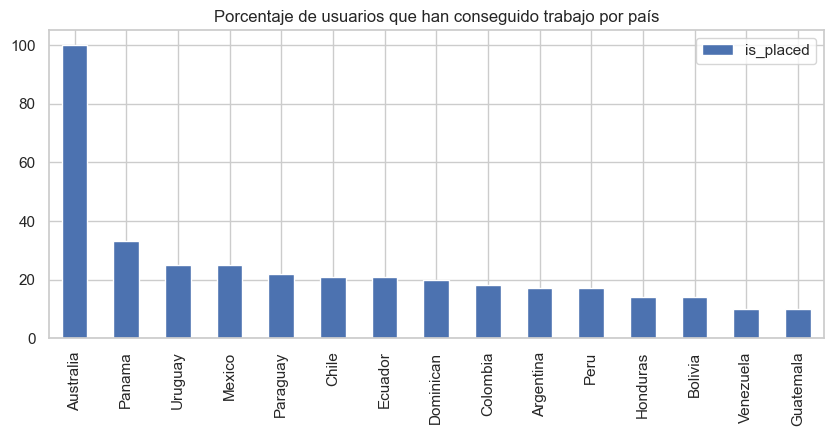

In [1458]:
# 4. Identificar de qué países provienen las personas que han conseguido trabajo 
# ¿Qué países consideran que son los mejores para obtener Talents?

user_data['is_placed'] = np.where(user_data['user_status']=='Placed', 1, 0)
df_4 = user_data # Tabla para responder la pregunta 4

placed_por_pais = user_data.groupby('country')['is_placed'].sum()
placed_por_pais = placed_por_pais.to_frame().reset_index().sort_values(by='is_placed', ascending=False)
placed_por_pais.drop(placed_por_pais[placed_por_pais['is_placed'] == 0].index, inplace = True)

placed_perc_por_pais = round(user_data.groupby('country')['is_placed'].mean(), 2) * 100
placed_perc_por_pais = placed_perc_por_pais.to_frame().reset_index().sort_values(by='is_placed', ascending=False)
placed_perc_por_pais['is_placed'] = placed_perc_por_pais['is_placed'].astype({'is_placed':'int64'})
placed_perc_por_pais.drop(placed_perc_por_pais[placed_perc_por_pais['is_placed'] == 0].index, inplace = True)

placed_por_pais.plot.bar(x='country', y='is_placed')
plt.title('Número de usuarios que han conseguido trabajo por país')
plt.xlabel('')
plt.show()

placed_perc_por_pais.plot.bar(x='country', y='is_placed',)
plt.title('Porcentaje de usuarios que han conseguido trabajo por país')
plt.xlabel('')
plt.show()


# ¿Qué países se consideran los mejores para obtener Talents?
México (40), Perú (28) y Colombia (22) representan los países donde más personas han conseguido trabajo. Dichos países tienen un % de "placed" de  25, 17 y 18, respectivamente. Por esta razón, podemos decir que México es el mejor país para conseguir talentos, seguido de Perú y Colombia. Sin embargo, al tener porcentajes de talentos captados similares en toda Latinoamérica, no se recomienda enfocar la búsqueda únicamente en los tres países mencionados. 

Además, en caso de buscar expandir hacia otros continentes, podría ser relevante empezar por Australia, ya que el único usuario que aplicó, consiguió trabajo*.

*Importante verificar primero con el equipo si este registro no se trató de un error de tipeo o de country code.

In [1459]:
# 5. Identificar qué skills son los que diferencian un perfil de otro.

# Para definir mejor los skills que caracterizan un perfil, tomaremos únicamente los usuarios que ya han conseguido trabajo.
placed_users = user_data[user_data['is_placed']==1]
placed_users.rename(columns={'id':'user_id'}, inplace=True)

# Construccion de una tabla con los skills de cada usuario aceptado, a la cual le anadiremos: developer type y skill type
# Filtrar solo usuarios aceptados
placed_users_df = user_skills.merge(placed_users, on='user_id', how='inner')
placed_users_df.rename(columns={'years':'skill_years'}, inplace=True)
placed_users_df.drop('id', inplace=True, axis=1)

# Agregar el nombre del skill
skills.rename(columns={'id':'skill_id'}, inplace=True)
skills = skills[['skill_id', 'name', 'skill_type_id']]
placed_users_df = placed_users_df.merge(skills, on='skill_id', how='left')
placed_users_df.rename(columns={'name':'skill_name'}, inplace=True)

# Agregar el developer type
developer_types.rename(columns={'id':'developer_type_id'}, inplace=True)
developer_type_df = user_developer_types.merge(developer_types, on='developer_type_id', how='left')
# (Notese que un usuario puede tener mas de un developer type)
developer_type_df = developer_type_df[['user_id', 'name']]
developer_type_df.rename(columns={'name':'developer_type'}, inplace=True)
placed_users_df = placed_users_df.merge(developer_type_df, on='user_id', how='left')

# Agregar el skill type
skill_types.rename(columns={'id':'skill_type_id', 'name':'skill_type'}, inplace=True)
skill_types = skill_types[['skill_type_id', 'skill_type']]
placed_users_df = placed_users_df.merge(skill_types, on='skill_type_id', how='left')

# Removamos columnas que no aportan para contestar la pregunta 5 y data sin developer type asociado:
placed_users_df = placed_users_df.drop(['skill_id', 'activated_at', 'user_status', 'working_status', 'country', 'continent', 'is_placed', 'skill_type_id', ], axis=1)
placed_users_df.drop(placed_users_df[placed_users_df['developer_type'].isna()].index, inplace = True)
df_5 = placed_users_df # Tabla para responder la pregunta 5
df_5.to_csv('df_5.csv')


C:\Users\mauro\AppData\Local\Temp\ipykernel_10928\706608844.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placed_users.rename(columns={'id':'user_id'}, inplace=True)


In [1460]:
# Creemos un df para cada developer type para armar los graficos en Tableau
df_5[df_5['developer_type']=='Front-End Developer'].to_csv('df_5_front.csv')
df_5[df_5['developer_type']=='Back-End Developer'].to_csv('df_5_back.csv')
df_5[df_5['developer_type']=='Fullstack Developer'].to_csv('df_5_full.csv')
df_5[df_5['developer_type']=='Mobile Developer'].to_csv('df_5_mob.csv')
df_5[df_5['developer_type']=='DevOps Engineer'].to_csv('df_5_devops.csv')
df_5[df_5['developer_type']=='QA Engineer'].to_csv('df_5_qa.csv')
df_5[df_5['developer_type']=='DBA'].to_csv('df_5_dba.csv')
df_5[df_5['developer_type']=='Data Scientist'].to_csv('df_5_ds.csv')
df_5[df_5['developer_type']=='UX Designer'].to_csv('df_5_ux.csv')

# Identificar qué skills son los que diferencian un perfil de otro.

Es importante aclarar, que mismos skills pueden pertenecer a diferentes tipos a la vez. Por ejemplo, MySQL es tanto un lenguaje de programación, como una base de datos. Dicho esto, vamos a interpretar los resultados obtenidos en las gráficas realizadas en Tableau:

Los skills que diferencian los perfiles según developer type son:
## Front-End Developers
#### Lenguajes de Programación 
- JavaScript Frontend
- HTML/CSS
#### Bases de datos
- MySQL
#### Framework & Librerías
- react

## Back-End Developers
#### Bases de datos
- MySQL
#### Lenguajes de Programación 
- JavaScript Frontend
- Java
- HTML/CSS
- SQL

## Fullstack Developers
Igual que para Back-End developers, solo que cambiando el orden entre Java y HTML/CSS

## Mobile Developers
Para este dipo de developers, entran los 5 skill types dentro del Top 5 skills,  por lo que este es un perfil muy variado. El top 3 Skill Types más predominantes con sus respectivos skills son:
#### Mobile
- Java
- Android
- Flutter
#### Bases de datos
- Firebase
- MySQL
#### Framework & Librerías
- Firebase
- Android
- Flutter

## DevOps Engineer
Se repite la alta variedad dada en Mobile Developers. Se resalta el Top 3 Skill types:
#### Lenguajes de Programación 
- JavaScript Front-End
- SQL
- Java
- HTML/CSS
#### Infraestrucutra
- Docker
- Azure
#### Framework & Librerías
- Git

## QA Engineer
Se repite la alta variedad dada en Mobile Developers y DevOps Engineers. Se resalta el Top 2 Skill types:
#### Lenguajes de Programación 
- JavaScript Front-End
- HTML/CSS
- C#
#### Bases de datos
- MySQL
- Postgres
- Firebase

## DBA
Predominan los lenguajes de programación y las bases de datos:
#### Lenguajes de Programación 
- Java
- SQL
- JavaScript Front-End
#### Bases de datos
- MySQL
- SQLServer

## Data Scientist
Predominan los lenguajes de programación, infraestructura y las bases de datos:
#### Lenguajes de Programación 
- SQL
- Python
- JavaScript Front-End
- HTML/CSS
#### Infraestructura
- Github
- AWS
#### Bases de datos
- MySQL

(Text(0.5, 0, 'Seniority'), Text(0, 0.5, ''))

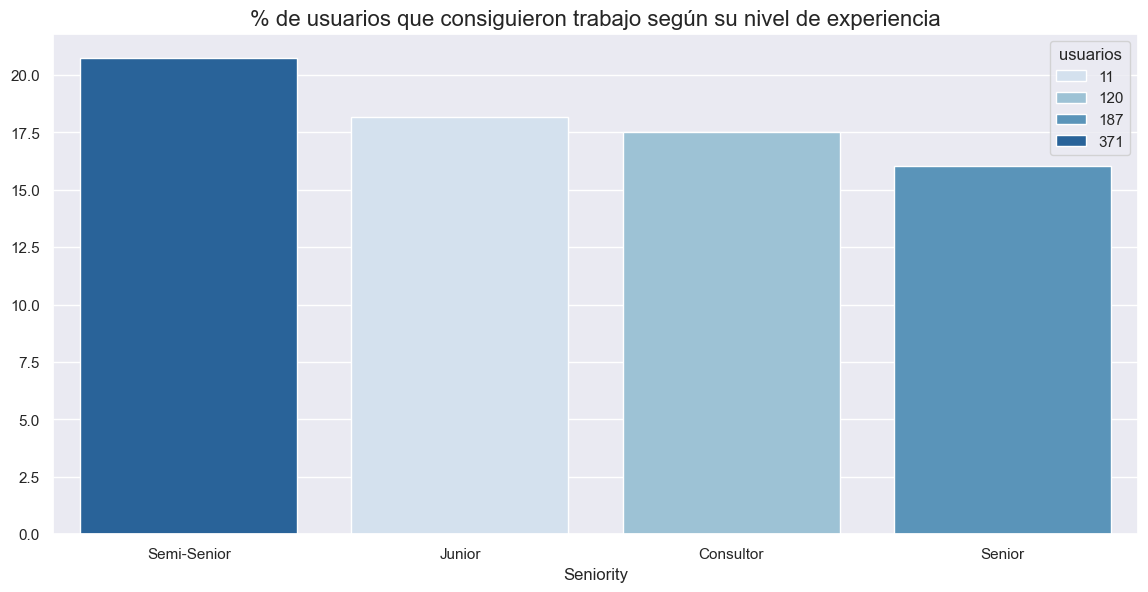

In [1461]:
# 1. Identificar qué perfiles de desarrollador nos conviene aceptar más en el programa.
# Años de Experiencia: Seniority
conditions_sen = [
    (user_data['experience_years'] >= 0) & (user_data['experience_years'] < 2),
    (user_data['experience_years'] >= 2) & (user_data['experience_years'] < 6),
    (user_data['experience_years'] >= 6) & (user_data['experience_years'] < 10),
    (user_data['experience_years'] >= 10)
]
values_sen = ['Junior', 'Semi-Senior', 'Senior', 'Consultor']
user_data['seniority'] = np.select(conditions_sen, values_sen)
user_data

user_data_sen = user_data.groupby('seniority').agg({'is_placed':'mean', 'id':'count'})
user_data_sen.reset_index(inplace=True)
user_data_sen.drop(user_data_sen[user_data_sen['seniority'] == '0'].index, inplace=True)
user_data_sen.sort_values(by='is_placed', inplace=True, ascending=False)
user_data_sen.rename(columns={'id':'usuarios'}, inplace=True)
user_data_sen['is_placed'] = user_data_sen['is_placed'] * 100
sns.color_palette("Blues", as_cmap=True)
sns.set(rc={'figure.figsize':(14,6.5)})
sns.barplot(data=user_data_sen, x = 'seniority', y='is_placed', hue='usuarios', palette='Blues', dodge=False)
plt.title('% de usuarios que consiguieron trabajo según su nivel de experiencia', fontdict={'fontsize': 16})
plt.xlabel('Seniority'), plt.ylabel('')


Text(0.5, 1.0, '% de usuarios que consiguieron trabajo según su estatus laboral')

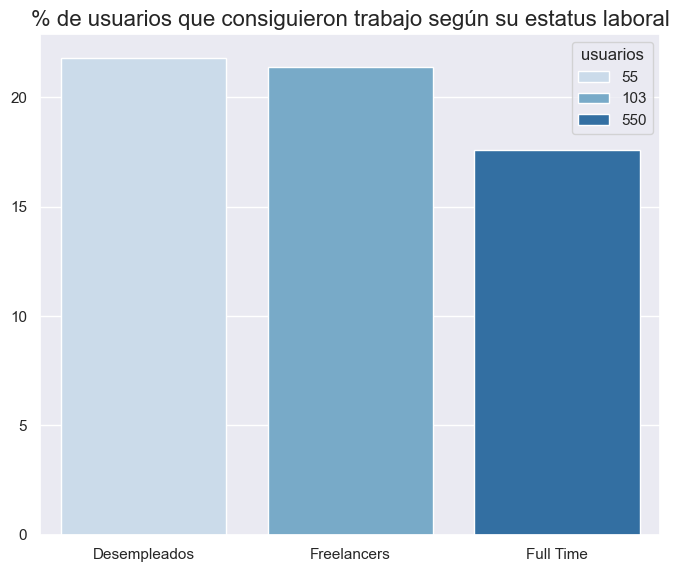

In [1462]:
# Working status
user_data_ws = user_data.groupby('working_status').agg({'is_placed':'mean', 'id':'count'})
user_data_ws.reset_index(inplace=True)
user_data_ws['is_placed'] = round(user_data_ws['is_placed'] * 100, 1)
user_data_ws.rename(columns={'id':'usuarios'}, inplace=True)
user_data_ws.replace({'No tengo trabajo':'Desempleados', 'Trabajo Freelance':'Freelancers', 'Trabajo Full Time':'Full Time'}, inplace=True)
sns.color_palette("Blues", as_cmap=True)
sns.set(rc={'figure.figsize':(8,6.5)})
sns.barplot(data=user_data_ws, x = 'working_status', y='is_placed', hue='usuarios', palette='Blues', dodge=False)
plt.xlabel(''), plt.ylabel('')
plt.title('% de usuarios que consiguieron trabajo según su estatus laboral', fontdict={'fontsize': 16})

In [1463]:
user_data

,id,activated_at,user_status,experience_years,working_status,country,continent,is_placed,seniority
0,4,2020-05-21 18:04:53,Placed,NaN,NaN,NaN,NaN,1,0
1,5,2020-05-21 18:55:28,Tester,3.0,Trabajo Freelance,Peru,Sudamérica y El Caribe,0,Semi-Senior
2,7,2020-06-12 19:49:58,Tester,12.0,Trabajo Full Time,Peru,Sudamérica y El Caribe,0,Consultor
3,9,2020-06-15 21:09:50,Placed,NaN,NaN,NaN,NaN,1,0
4,11,2020-06-16 01:37:40,Activo,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...
954,1065,2021-05-14 00:41:55,Activo,NaN,NaN,NaN,NaN,0,0
955,1066,2021-05-14 18:01:02,Activo,NaN,NaN,NaN,NaN,0,0
956,1067,2021-05-14 18:03:19,Activo,NaN,NaN,NaN,NaN,0,0
957,1068,2021-05-14 18:08:19,Activo,NaN,NaN,NaN,NaN,0,0


# Identificar qué perfiles de desarrollador nos conviene aceptar más en el programa
- Seniority: Los Semi-Senior (2-5 años de experiencia) tienen una leve ventaja para ser contratados con un 20,7%; y los Seniors (6-9 años) son los que menos porcentaje tienen (16,0%). Muy pocos juniors si quiera ingresan al programa.
- Working status: Más del 75% de los empleados que entran al programa se encuentran trabajando Full-Time, sin embargo, los que cumplen esta cualidad son los que menos probabilidades tienen de conseguir trabajo, con un 17.6%. Los desempleados y freelancers tienen una ligera ventaja de tasa de captación, con un 21.8% y 21.4%, respectivamente.

        developer_type  is_placed  dev types dev_types
7          QA Engineer       22.7         22      0-49
4  Front-End Developer       22.2        257      150+
6     Mobile Developer       20.7        116    50-149
3      DevOps Engineer       18.9         53    50-149
5  Fullstack Developer       18.9        359      150+
0   Back-End Developer       18.5        378      150+
1                  DBA       18.5         65    50-149
2       Data Scientist       15.2         33      0-49
8          UX Designer        0.0         13      0-49


(Text(0.5, 0, ''), Text(0, 0.5, ''))

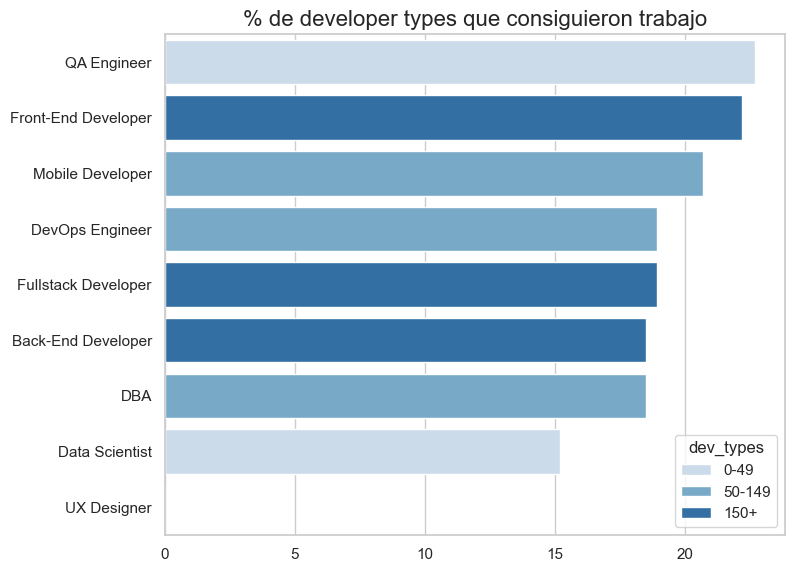

In [1464]:
# 6. Búsqueda de otros insights
# % de placed por Developer type
user_data.rename(columns={'id':'user_id'}, inplace=True)
user_dev_type = developer_type_df.merge(user_data, on='user_id', how='left')
user_dev_type = user_dev_type[['user_id', 'developer_type', 'is_placed']]
user_dev_type.reset_index(inplace=True)
user_dev_type_rates = user_dev_type.groupby('developer_type').agg({'is_placed':'mean', 'index':'count'})
user_dev_type_rates.reset_index(inplace=True)
user_dev_type_rates.rename(columns={'index':'dev types'}, inplace=True)
user_dev_type_rates['is_placed'] = round(user_dev_type_rates['is_placed']*100, 1)
user_dev_type_rates.sort_values(by='is_placed', ascending=False, inplace=True)
conditions_dt = [
    (user_dev_type_rates['dev types'] < 50), 
    (user_dev_type_rates['dev types'] >= 50) & (user_dev_type_rates['dev types'] < 150), 
    (user_dev_type_rates['dev types'] > 150)
    ]
values_dt = ['0-49', '50-149', '150+']
user_dev_type_rates['dev_types'] = np.select(conditions_dt, values_dt)
print(user_dev_type_rates)

sns.color_palette("Blues", as_cmap=True)
sns.set(rc={'figure.figsize':(8,6.5)})
sns.set_theme(style="whitegrid")
sns.barplot(y='developer_type', x='is_placed', hue='dev_types', hue_order=['0-49', '50-149', '150+'], data=user_dev_type_rates, palette="Blues", dodge=False)
plt.title('% de developer types que consiguieron trabajo', fontdict={'fontsize': 16})
plt.xlabel(''), plt.ylabel('')

# ¿Cuáles son los Developer Types que más consiguen trabajo?
Es importante recordar que un mismo usuario puede tener varios developer types. Los 3 developer types más comunes son Back-End, Fullstack y Front-End; y los 3 menos comunes son UX Designer, QA Engineer y Data Scientist. Dicho esto, podemos concluir sobre que tipos de developer consiguen más trabajo:
- No hay una diferencia marcada entre todos los grupos: QA Engineer tiene el mejor porcentaje con 22,7% y Data Scientist el peor con 15,2%.
- QA Engineer, Front-End y Mobile Developers son los únicos que superan el 20%.
- De los 13 UX Designers, ninguno consiguió trabajo.

   dt_count  is_placed  usuarios
0         1       15.2       341
1         2       19.7       173
2         3       22.5       120
3         4       19.6        51
4         5       22.2         9


(Text(0.5, 0, 'Developer types por usuario'), Text(0, 0.5, '% de placement'))

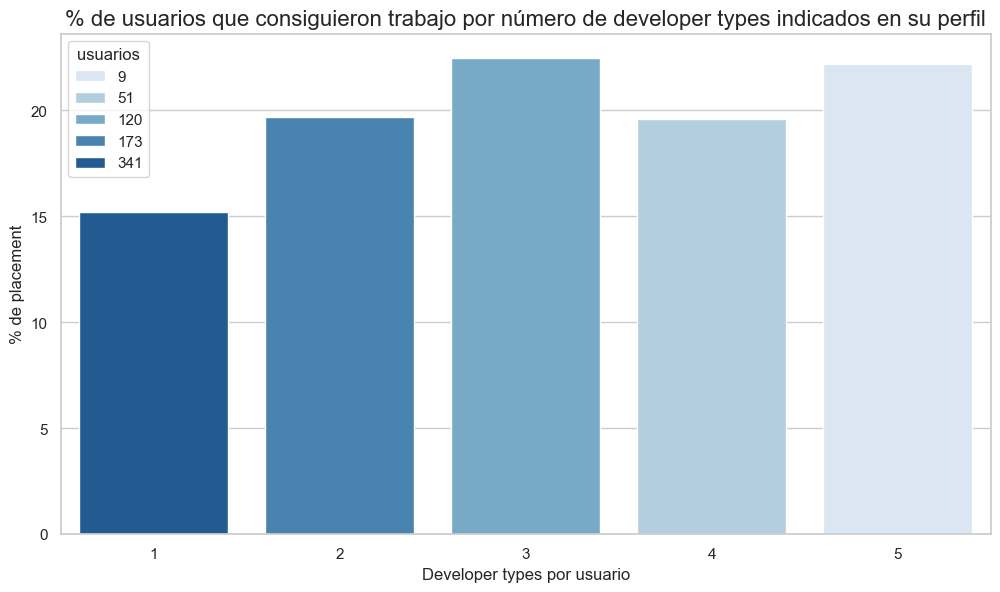

In [1465]:
# 6. Otros Insights Pt. 2
# % de placed por numero de developer types por usuario
dts_per_user = user_dev_type.groupby('user_id')['developer_type'].count()
dts_per_user = dts_per_user.to_frame().reset_index()
dts_per_user.rename(columns={'developer_type':'dt_count'}, inplace=True)
user_data = user_data.merge(dts_per_user, on='user_id', how='left')
user_dt_count = user_data[['user_id', 'is_placed', 'dt_count']]
user_dt_count = user_dt_count.groupby('dt_count').agg({'is_placed':'mean', 'user_id':'count'})
user_dt_count.reset_index(inplace=True)
user_dt_count['is_placed'] = round(user_dt_count['is_placed']*100, 1)
user_dt_count['dt_count'] = user_dt_count['dt_count'].astype('int64')
user_dt_count.rename(columns={'user_id':'usuarios'}, inplace=True)
print(user_dt_count)

sns.color_palette("Blues", as_cmap=True)
sns.set(rc={'figure.figsize':(12,6.5)})
sns.set_theme(style="whitegrid")
sns.barplot(y='is_placed', x='dt_count', hue='usuarios', data=user_dt_count, palette="Blues", dodge=False)
plt.title('% de usuarios que consiguieron trabajo por número de developer types indicados en su perfil', fontdict={'fontsize': 16})
plt.xlabel('Developer types por usuario'), plt.ylabel('% de placement')

# ¿Influye el número de developer types en las posibilidades de encontrar trabajo?
Son muchos más comunes los usuarios que solo pertenezcan a un developer type (341). Sin embargo, es considerable la cantidad de profesionales con 2 (173), 3 (120), 4 (51) y hasta 5 (9) developer types.
Los usuarios que más consiguen trabajo son aquellos con 3 y 5 developer types, seguidos de los que tienen 2 y 4, y en útimo lugar, los de un solo tipo.

Idiomas conocidos por todos los usuarios: 
 name
Alemán        14
Español      423
Francés       29
Inglés       694
Portugués     45
Name: user_id, dtype: int64
Tasa de trabajo encontrado según el nivel de inglés: (1: básico), (4: fluído) 
    english_level  is_placed  usuarios
0            1.0        9.4       149
1            2.0       20.6       354
2            3.0       24.7       154
3            4.0       13.5        37


(Text(0.5, 0, 'Nivel de inglés (1: básico), (4: fluído)'), Text(0, 0.5, ''))

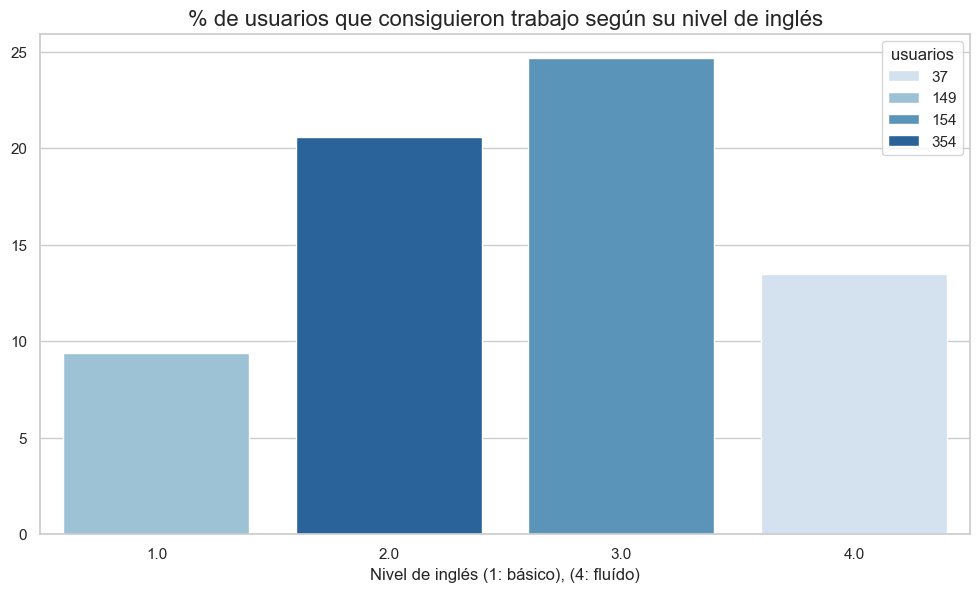

In [1466]:
# 6. Otros Insights Pt. 3
# Lenguajes
languages.rename(columns={'id':'language_id'}, inplace=True)
user_languages_n = user_languages.merge(languages, on='language_id', how='left')
user_languages_count = user_languages_n.groupby('name')['user_id'].count()
print('Idiomas conocidos por todos los usuarios: \n', user_languages_count)
# Filtraremos solo ingles para analizar los diferentes niveles en los usuarios. Los demás son minoritarios y el español no es de interés...
# ya que los developers son de América Latina y buscan trabajo en empresas globales.
user_languages_n = user_languages_n[user_languages_n['name']=='Inglés']
user_languages_n.rename(columns={'language_proficiency_id':'english_level'}, inplace=True)
user_languages_n = user_languages_n[['user_id', 'english_level']]
user_data = user_data.merge(user_languages_n, on='user_id', how='left')
aux = user_data #para analisis de ingles nivel 4.0
user_eng = user_data.groupby('english_level').agg({'is_placed':'mean', 'user_id':'count'})
user_eng.reset_index(inplace=True)
user_eng['is_placed'] = round(user_eng['is_placed']*100, 1)
user_eng.rename(columns={'user_id':'usuarios'}, inplace=True)
print('Tasa de trabajo encontrado según el nivel de inglés: (1: básico), (4: fluído) \n', user_eng)

sns.color_palette("Blues", as_cmap=True)
sns.set(rc={'figure.figsize':(12,6.5)})
sns.set_theme(style="whitegrid")
sns.barplot(y='is_placed', x='english_level', hue='usuarios', data=user_eng, palette="Blues", dodge=False)
plt.title('% de usuarios que consiguieron trabajo según su nivel de inglés', fontdict={'fontsize': 16})
plt.xlabel('Nivel de inglés (1: básico), (4: fluído)'), plt.ylabel('')

# ¿Influye el nivél de Inglés a la hora de conseguir trabajo?
El nivel de inglés del 51% de los usuarios es 2 (Nivel Intermedio). En la gráfica se puede apreciar como aumenta el % de encontrar trabajo a medida que incrementa el nivel de inglés, con excepción del útimo grupo (Nivel 4: Inglés fluído). Esta caída quizás pueda deberse a otros factores a parte del dominio de idioma, ya que es el grupo más pequeño de este análisis.

In [1467]:
# Analisis del grupo de ingles fluido
user_fluido = aux[aux['english_level']==4]
user_fluido.groupby('seniority').agg({'is_placed':'mean', 'user_id':'count'})


,is_placed,user_id
seniority,,
Consultor,0.250000,4
Junior,0.000000,2
Semi-Senior,0.166667,24
Senior,0.000000,7


# Modelo de Clasificación

## Indicadores de selección del mejor tipo de modelo de Clasificación
Se debe utilizar un modelo de clasificación ya que la variable a predecir es de tipo booleana: El usuario ha conseguido trabajo (Verdadero/Falso).

El primer tipo de modelo a probar será una Regresión Logística, debido a que a diferencia de otros modelos de clasificación, este se adapta bien cuando la variable a predecir es binaria.

Si este tipo de modelo no proporciona una capacidad de predicción relevante, probaremos otros tipos de modelo de clasificación. Los parámetros para decidir si este modelo es bueno son:
- Recall: la cual describe cuantas clases positivas son predecidas correctamente.
- Precisión: describe cuantas clases fueron positivas de todas las que predijimos como positivas.
- F1-Score o Sensitividad: representa el balance entre las dos anteriores. Puede alertar de un potencial desbalance en el desempeño del modelo.

Un modelo ¨funcional¨ debe tener al menos más de un 50% de recall para ambas clases (Placed [1] / Not Placed [0] ).

Un buen modelo requiere más de un 70-80% en dicho parámetro.

Además, la tasa de encontrar trabajo predecida por el modelo debe asemejarse a la real (19,2%).

## Variables a utilizar o descartar para el Modelo
Descarte de variables a usar en el modelo:
- skills: demasiadas categorías diferentes pueden complejizar de más el modelo. Además ya sabemos como relacionar los skills más relevantes a través del tipo de devoloper, gracias al analisis previo.
- user_status: ya que contiene la response variable (is_placed)
- seniority: ya tenemos los años de experiencia cuantificados en "experience_years"

Variables independientes a utilizar:
- experience_years
- working_status
- developer_type (debemos generar dummies múltiples ya que un mismmo usuario puede tener más de un dev type)
- country
- english_level
- dt_count

Variable a predecir: 
- is_placed

In [1468]:
print('Número de usuarios: ', user_data.shape[0], '\n')
# Es útil el continente?
print(user_data.groupby('continent')['user_id'].count(), '\n')
print('Número de usuarios en USA: ', user_data[user_data['country']=='United States']['user_id'].count(), '\n')
print('Número de usuarios en Canada: ', user_data[user_data['country']=='Canada']['user_id'].count(), '\n')
# No usaremos el continente, el 99,4% de los usuarios están en Latinoamérica.
user_data.drop(columns=['continent', 'activated_at', 'user_status', 'seniority'], inplace=True)

Número de usuarios:  959 

continent
Europa                      1
Norte y Centroamérica     213
Oceanía                     1
Sudamérica y El Caribe    471
África                      2
Name: user_id, dtype: int64 

Número de usuarios en USA:  1 

Número de usuarios en Canada:  1 



In [1469]:
# Generacion de dummy variables para dev type
user_dev_type = user_dev_type[['user_id', 'developer_type']]
user_dt_dum = user_dev_type.groupby(['user_id', 'developer_type']).size().unstack(fill_value=0)
user_data = user_data.merge(user_dt_dum, on='user_id', how='left')

In [1470]:
# Hay alguna variable de interés con muchos null values?
print('Null values por columna: \n', user_data.isna().sum())

# Removeremos todos los nulls de esas columnas
user_data.dropna(inplace=True)

Null values por columna: 
 user_id                  0
experience_years       270
working_status         251
country                271
is_placed                0
dt_count               265
english_level          265
Back-End Developer     265
DBA                    265
Data Scientist         265
DevOps Engineer        265
Front-End Developer    265
Fullstack Developer    265
Mobile Developer       265
QA Engineer            265
UX Designer            265
dtype: int64


In [1471]:
# Generar resto de dummy variables (working_status & country)
working_status = pd.get_dummies(user_data['working_status'], drop_first=True)
country = pd.get_dummies(user_data['country'], drop_first=True)
user_data = pd.concat([user_data, working_status, country], axis=1)
user_data.head()

,user_id,experience_years,working_status,country,is_placed,dt_count,english_level,Back-End Developer,DBA,Data Scientist,...,Honduras,Madagascar,Mexico,Nicaragua,Panama,Paraguay,Peru,United States,Uruguay,Venezuela
1,5,3.0,Trabajo Freelance,Peru,0,4.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
17,49,9.0,Trabajo Full Time,Mexico,0,1.0,2.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
19,51,5.0,No tengo trabajo,Mexico,1,3.0,2.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
25,57,6.0,Trabajo Full Time,Mexico,0,3.0,1.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
26,59,3.0,Trabajo Full Time,Mexico,0,4.0,1.0,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [1472]:
# Despues de la limpieza, nos restan 640 usuarios. Veamos cual es la tasa de encontrar trabajo:
user_data['is_placed'].value_counts(normalize=True)
# La tasa de encontrar trabajo es 19.2%

# Terminos de eliminar las columnas que no hacen falta
user_data.drop(columns=['working_status', 'country'], axis=1, inplace=True)


In [1473]:
# Eliminar la variable dependiente y almacenarla
labels = user_data['is_placed']
user_data = user_data.drop(['is_placed'], axis = 1)

# Convertir a numeric para poder usar las funciones del modelo
user_data = user_data.apply(pd.to_numeric)

## Implementando el Modelo

In [1474]:
# Modelo: Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [1475]:
# Logistic Regression 1. Separamos la data en training y test set (70/30)
X_train, X_test, y_train, y_test = train_test_split(user_data, labels, test_size=0.3, random_state=0)

In [1476]:
# Entrenamos el modelo y hacemos predicciones
logmodel = LogisticRegression(max_iter=1000) 
logmodel.fit(X_train, y_train)
predictions_log = logmodel.predict(X_test)
# 100 iteraciones no fueron suficientes: La data no ajusta bien al modelo. Con 1000 si convergió, en un tiempo corto de 0.8s

In [1477]:
# Evaluación del modelo
# Report de desempeño
print(classification_report(y_test, predictions_log), '\n')

# Confusion matrix
print(confusion_matrix(y_test, predictions_log))
# TP: Not placed predicted correctly (149)
# FP: Placed predicted as Not Placed (32)

# FN: Not placed predicted as Placed (8)
# TN: Placed predicted correctly (3)

# El modelo predijo 181 de 192 como Not Placed: es decir, 6% de placements (vs. el 19% real)

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       157
           1       0.27      0.09      0.13        35

    accuracy                           0.79       192
   macro avg       0.55      0.52      0.51       192
weighted avg       0.72      0.79      0.74       192
 

[[149   8]
 [ 32   3]]


In [1478]:
# Estudio de la importancia de las variables: para entender mejor el desempeño del modelo
# Get the feature importance
importance = logmodel.coef_.flatten()

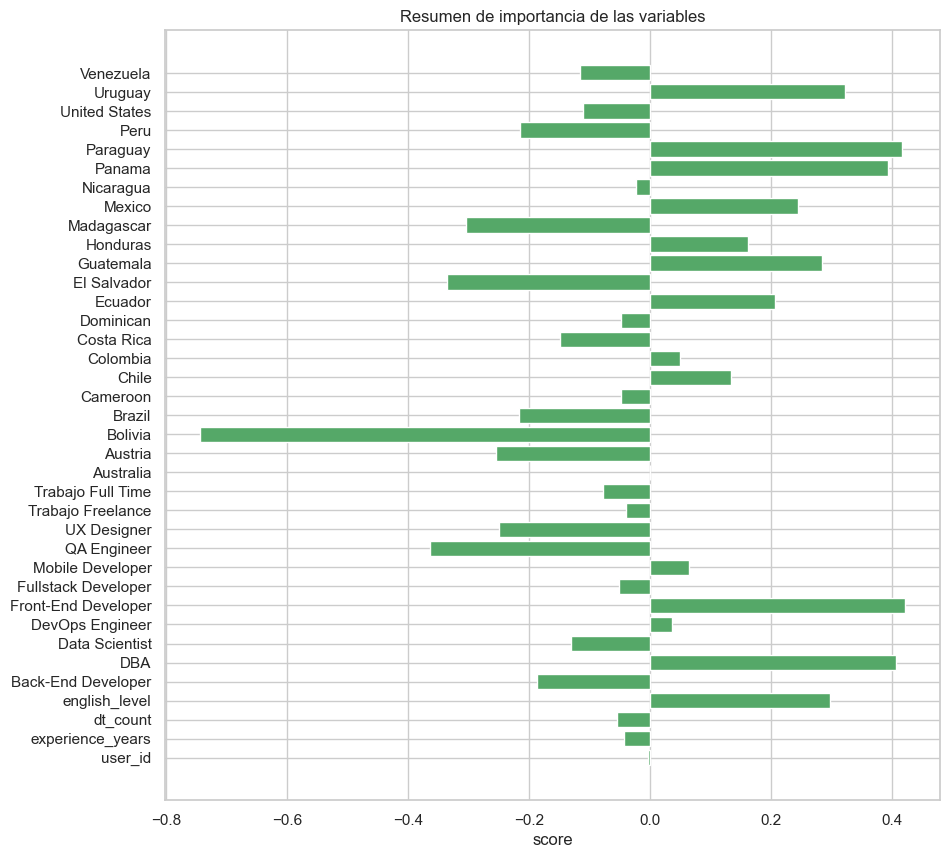

In [1479]:
# Grafiquemos las importancias de las variables
plt.rcParams['figure.figsize'] = (10,10)
plt.barh(user_data.columns, importance, color = 'g')
plt.title('Resumen de importancia de las variables')
plt.xlabel('score')
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       157
           1       0.30      0.09      0.13        35

    accuracy                           0.80       192
   macro avg       0.56      0.52      0.51       192
weighted avg       0.73      0.80      0.75       192
 

[[150   7]
 [ 32   3]]


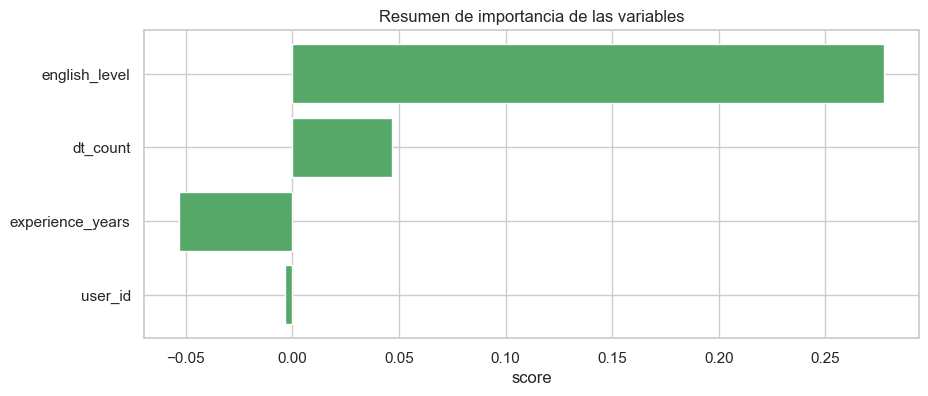

In [1480]:
# Logistic Regression 2. Probemos realizar el modelo solo usando variables numericas
user_data = user_data[['user_id', 'experience_years', 'dt_count', 'english_level']]
X_train, X_test, y_train, y_test = train_test_split(user_data, labels, test_size=0.3, random_state=0)


logmodel = LogisticRegression(max_iter=1000) 
logmodel.fit(X_train, y_train)
predictions_log = logmodel.predict(X_test)

print(classification_report(y_test, predictions_log), '\n')
print(confusion_matrix(y_test, predictions_log))
# Este modelo es mejor que el anterior (mejora casi insignificante), pero sugiere que podemos remover las variables categóricas.

importance = logmodel.coef_.flatten()
# Grafiquemos las importancias de las variables
plt.rcParams['figure.figsize'] = (10,4)
plt.barh(user_data.columns, importance, color = 'g')
plt.title('Resumen de importancia de las variables')
plt.xlabel('score')
plt.show()

In [1481]:
# Logistic Regression 3. Igual que el 2, pero pre-procesando las variables numéricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer

X_train, X_test, y_train, y_test = train_test_split(user_data, labels, test_size=0.3, random_state=0)
num_columns = ['user_id', 'experience_years', 'dt_count', 'english_level']
ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

logmodel = LogisticRegression(max_iter=1000) 
logmodel.fit(X_train, y_train)
predictions_log = logmodel.predict(X_test)

print(classification_report(y_test, predictions_log), '\n')
print(confusion_matrix(y_test, predictions_log))
# Modelo levemente mejor que el 2do, pero no funcional aun. Debemos probar otro tipo de clasificación. 

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       157
           1       0.33      0.09      0.14        35

    accuracy                           0.80       192
   macro avg       0.58      0.52      0.51       192
weighted avg       0.74      0.80      0.75       192
 

[[151   6]
 [ 32   3]]


## Cuantificación de las variables que generan mayor impacto
Esto se observa en el gráfico de importancia de las variables. Ninguna de las variables utilizadas logró alcanzar una importancia significativa para darle un poder de predicción al modelo, sin embargo, las que aportaron en orden de importancia fueron (entre paréntesis se coloca el resultad que predicen al aumentar):
- english_level (placed)
- experience_years (not placed)
- dt_count (placed)

# Recomendaciones Finales
## Variables existentes a considerar
- usar activated_at: convertir esta variable a "numero de dias/meses que el usuario lleva en Talently"
## Variables nuevas por buscar
- Salario actual
- Último salario
- Expectativa Salarial
- Ha trabajado en un empresa global? (Si/No)
- Developer type principal
- Mes de contratación (Solo para placed users)
## Modelo
- Probar otros tipos de modelo
- Estudiar la correlación entre las variables independientes y eliminar las altamente correladas
- Agregar las variables mencionadas en la sección anterior
- Seguir tomando registros para agregar más observaciones (usuarios) al modelo
